In [2]:
#%% Function definition and imports
import numpy.typing as npt
import LS_Functions as lsf
import aicspylibczi as czi
import numpy as np
import math
import sys

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from skimage.util import img_as_float
from fast_histogram import histogram2d, histogram1d
from scipy.optimize import fmin_cobyla
from skimage.transform import downscale_local_mean
from skimage.util import img_as_float
from tqdm import tqdm
def make_non_singular(matrix, epsilon=1e-9):
    """
    Checks if a matrix is singular and adds a small number to its diagonal
    until it becomes non-singular.

    Args:
        matrix (np.ndarray): The input square matrix.
        epsilon (float): The small number to add to the diagonal.

    Returns:
        np.ndarray: A non-singular version of the input matrix.
    """
    # Create a copy to avoid modifying the original matrix in-place
    modified_matrix = matrix.copy()

    # Use a small tolerance for floating-point comparisons
    tolerance = 1e-12

    # Check the determinant in a loop in case multiple additions are needed
    while np.abs(np.linalg.det(modified_matrix)) < tolerance:
        print("Matrix is singular. Adding epsilon to the diagonal.")
        modified_matrix += epsilon * np.eye(modified_matrix.shape[0])

    return modified_matrix

def shannon_entropy(a: npt.NDArray) -> float:
    """
    This runs very often, so we should do our best to make this fast.
    See 'profiling/shannon-entropy.ipynb' for why this was chosen
    """
    # seems like flattened arrays are faster, but .flatten() produces a copy so we
    # stick with .ravel()
    a = a.ravel()
    a /= a.sum()
    a = a[np.nonzero(a != 0)]
    a *= np.log2(a)
    return -a.sum().item()
def mutual_information(x: npt.NDArray, y: npt.NDArray, *, bins=100) -> float:
    try:
        x = x.ravel()
        y = y.ravel()

        x_range = (x.min(), x.max())
        y_range = (y.min(), y.max())

        # TODO: even though fast-histogram is pretty dang fast, consider boost-histogram?
        #  measure perf diff
        c_xy = histogram2d(x, y, bins, (x_range, y_range))
        c_x = histogram1d(x, bins, x_range)
        c_y = histogram1d(y, bins, y_range)

        h_xy = shannon_entropy(c_xy)
        h_x = shannon_entropy(c_x)
        h_y = shannon_entropy(c_y)
    except:
        print('something wrong!')
        h_x = 100
        h_y = 100
        h_xy = 100
    return h_x + h_y - h_xy
def mutual_information_range(x: npt.NDArray, y: npt.NDArray, *, bins=256) -> float:
    try:
        x = x.ravel()
        y = y.ravel()
        Range = np.min([x.nanmin(), y.nanmin()]), np.max([x.nanmax(), y.nanmax()])
        # TODO: even though fast-histogram is pretty dang fast, consider boost-histogram?
        #  measure perf diff
        c_xy = histogram2d(x, y, bins, (Range, Range))
        c_x = histogram1d(x, bins, Range)
        c_y = histogram1d(y, bins, Range)

        h_xy = shannon_entropy(c_xy)
        h_x = shannon_entropy(c_x)
        h_y = shannon_entropy(c_y)
    except:
        print('something wrong!')
        h_x = 100
        h_y = 100
        h_xy = 100
    return h_x + h_y - h_xy
def regional_mi(x: npt.NDArray, y: npt.NDArray) -> float:
    """
    FIXME not optimized, but doesn't give us better results than regular mi, so not
     worth it at the moment
    """
    x = np.copy(x)
    y = np.copy(y)

    x /= x.max()
    y /= y.max()

    r = 1

    stack = []
    for ri in range(2 * r):
        for rj in range(2 * r):
            stack.append(x[ri : -2 * r + ri, rj : -2 * r + rj])
    for ri in range(2 * r):
        for rj in range(2 * r):
            stack.append(y[ri : -2 * r + ri, rj : -2 * r + rj])
    stack = np.stack(stack)
    stack = np.reshape(stack, (stack.shape[0], -1))

    dim, n_points = stack.shape[:2]
    hdim = dim // 2

    mean = np.mean(stack, axis=1, keepdims=True)
    stack -= mean
    cov = stack @ stack.T / n_points
    h_xy = math.log(np.linalg.det(cov))
    h_x = math.log(np.linalg.det(cov[:hdim, :hdim]))
    h_y = math.log(np.linalg.det(cov[hdim:, hdim:]))
    return h_x + h_y - h_xy
def minimize_mi(x: npt.NDArray, y: npt.NDArray, *, init_alpha=0.0) -> float:
    def func(alpha: npt.NDArray):
        return mutual_information(x, y - alpha * x)

    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=np.array([init_alpha]),
        cons=[lambda a: a],
        rhobeg=1e-2,
        rhoend=1e-8,
    )
    return result.item()
def compute_unmixing_matrix(
    image: npt.NDArray,
    *,
    max_iters=1000,
    step_mult=0.1,
    verbose=False,
    return_iters=False,
) -> npt.NDArray:
    assert image.ndim == 3  # CYX
    n_channels = image.shape[0]

    image = img_as_float(image)
    image_orig = image.copy()

    mat_cumul = np.eye(n_channels, dtype=float)
    mat_last = np.eye(n_channels, dtype=float)

    mats = []
    for _ in tqdm(
        range(max_iters),
        disable=not verbose,
        desc="Unmixing iterations",
        total=0,
        file=sys.stdout,
    ):
        mat = np.eye(n_channels, dtype=float)

        for row in range(n_channels):
            for col in range(n_channels):
                if row == col:
                    continue

                coef = minimize_mi(
                    image[col], image[row], init_alpha=mat_last[row, col]
                )
                mat[row, col] = -step_mult * coef

        # check this early on
        if np.allclose(mat, mat_last):
            break
        mat_last = mat.copy()

        # update matrix
        assert mat_cumul.shape == (n_channels, n_channels)
        mat_cumul = mat @ mat_cumul

        # constrain coefficients to 1.0 along the diagonal, and negative for
        # off-diagonal entries
        for row in range(n_channels):
            for col in range(n_channels):
                if row == col:
                    mat_cumul[row, col] = 1.0
                else:
                    if mat_cumul[row, col] > 0.0:
                        mat_cumul[row, col] = 0.0
        mats.append(mat_cumul.copy())

        # update the next iteration of image
        assert mat_cumul.shape == (n_channels, n_channels)
        assert image.ndim == 3
        # several times faster than np.einsum
        image = np.tensordot(mat_cumul, image_orig, axes=1)

    if return_iters:
        return np.stack(mats)
    else:
        return mats[-1]
def generate_equally_spaced_n_dim_points(N_comp, modulation=0.95):
    """
    Generates N_comp N_comp-dimensional points equally spaced in phase.

    Args:
        N_comp (int): The number of points and the dimensionality.
        modulation (float): The modulation value, which must be < 1.

    Returns:
        np.ndarray: An array of shape (N_comp, N_comp) containing the points.
    """
    if not 0 < modulation < 1:
        raise ValueError("Modulation must be between 0 and 1.")

    # Create an array to hold all the points
    points = np.zeros((N_comp, N_comp))

    # Calculate the phase for each point
    phases = (2 * np.pi * np.arange(N_comp)) / N_comp

    # A phase offset for each dimension to ensure equal spacing in the N-dim space
    # This is a key part of the corrected approach.
    dim_phase_offset = (2 * np.pi * np.arange(N_comp)) / N_comp

    for i in range(N_comp):
        for j in range(N_comp):
            # Calculate each coordinate for point 'i'
            # The coordinate is determined by its phase and a unique dimensional offset
            points[i, j] = modulation * np.cos(phases[i] + dim_phase_offset[j])
            
    return points
def compute_unmixing_matrix_phasor(img_spectral,N_comp):
    coord = np.zeros_like(img_spectral)[:N_comp]
    for i in range(N_comp):
        if i % 2 == 0: 
            n_harmonic = (i // 2) + 1
            g, s, ph, m = lsf.PhasorTransform_Slow_3D(img_spectral, axis=0, n_harmonic=n_harmonic)
            coord[i] = g
        else: 
            coord[i] = s
def unmix(coord,img_int,coord_pure,Shape):
    f = np.matmul(np.linalg.inv(coord_pure),coord.reshape(Shape[0],-1)).reshape(Shape)
    unmixed = f*img_int
    unmixed[np.isnan(unmixed)] = 0
    unmixed[np.isinf(unmixed)] = 0
    return np.abs(unmixed)
def minimize_mi_phasor(coord,img_int,coord_guess,Shape,i,j):
    init_alpha = coord_guess[i,j]
    def func(alpha: npt.NDArray):
        coord_guess[i,j] = alpha
        unmixed = unmix(coord,img_int,coord_guess,Shape)
        mi12 = mutual_information(unmixed[i], unmixed[j])
        #mi_int = mutual_information(unmixed.sum(0), img_int[0])
        #return mi12 + mi_int
        return mi12

    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=np.array([init_alpha]),
        cons=[lambda a: a],
        rhobeg=1e-2,
        rhoend=1e-8,
    )
    return result.item()

import numpy as np
import numpy.typing as npt
from scipy.optimize import fmin_cobyla

# Note: The functions unmix() and mutual_information() are assumed to be defined elsewhere.
# These are the core functions of your unmixing algorithm.

def minimize_mi_phasor_1shot(coord, img_int, coord_guess, Shape, i_comp,j_comp):
    """
    Minimizes the mutual information between a single component and all other
    components using the fmin_cobyla optimizer.

    This function is a corrected version of the user-provided code.

    Args:
        coord (np.ndarray): The phasor coordinates.
        img_int (np.ndarray): The intensity image.
        coord_guess (np.ndarray): The initial guess for the unmixing matrix.
        Shape (tuple): The shape of the original image (height, width).
        i_comp (int): The index of the component to be optimized.

    Returns:
        np.ndarray: The optimized unmixing matrix.
    """
    N_comp = len(coord_guess)

    def func(x: npt.NDArray):
        # fmin_cobyla passes a flattened array of parameters.
        # We must reshape it back into the unmixing matrix.
        coord_guess_matrix = x.reshape(N_comp, N_comp)
        
        # Perform the unmixing to get the component images.
        unmixed = unmix(coord, img_int, coord_guess_matrix, Shape)
        
        # The objective is to minimize the mutual information between the chosen
        # component and all other components. We use the average for a scalar objective.
        mi_int = mutual_information(unmixed.sum(0), img_int[0])
        mi12 = mutual_information(unmixed[i_comp], unmixed[j_comp])
        return mi12

    # --- Constraints ---
    # We want to constrain each element of the unmixing matrix to be between -1 and 1.
    # This requires two lambda functions for the upper and lower bounds.
    # The lambda function syntax `lambda a: ...` correctly handles the single
    # parameter `a` passed by fmin_cobyla, which is the flattened parameter array.
    cons = [
        lambda a: a + 1,  # Lower bound constraint: a >= -1
        lambda a: 1 - a   # Upper bound constraint: a <= 1
    ]

    # --- Optimization ---
    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=coord_guess.flatten(),  # The initial guess must be a 1D array.
        cons=cons,
    )
    
    # fmin_cobyla returns a flattened array. We reshape it back into the
    # unmixing matrix for the return value.
    return result.reshape(N_comp, N_comp)

def minimize_mi_phasor_1shot_v2(img_spectral, coord, coord_guess, i_comp,j_comp):
    N_comp = len(coord_guess)

    def func(x: npt.NDArray):
        # fmin_cobyla passes a flattened array of parameters.
        # We must reshape it back into the unmixing matrix.
        coord_guess_matrix = make_non_singular(x.reshape(N_comp, N_comp))

        # Perform the unmixing to get the component images.
        unmixed = GS2IMG(coord,coord_guess_matrix,img_spectral)
        unmixed[unmixed < 0] = 0
        # The objective is to minimize the mutual information between the chosen
        # component and all other components. We use the average for a scalar objective.
        mi12 = mutual_information(unmixed[i_comp], unmixed[j_comp])
        return mi12

    # --- Constraints ---
    # We want to constrain each element of the unmixing matrix to be between -1 and 1.
    # This requires two lambda functions for the upper and lower bounds.
    # The lambda function syntax `lambda a: ...` correctly handles the single
    # parameter `a` passed by fmin_cobyla, which is the flattened parameter array.
    cons = [
        lambda a: a + 1,  # Lower bound constraint: a >= -1
        lambda a: 1 - a   # Upper bound constraint: a <= 1
    ]

    # --- Optimization ---
    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=coord_guess.flatten(),  # The initial guess must be a 1D array.
        cons=cons,
    )
    
    # fmin_cobyla returns a flattened array. We reshape it back into the
    # unmixing matrix for the return value.
    return result.reshape(N_comp, N_comp)

from IPython.display import clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show()
    
def live_phasor_plot(data_dict, figsize=(10,5), title=''):
    colors = 'rbgkc'
    clear_output(wait=True)
    fig,ax = plt.subplots(1,2,figsize=figsize)
    for label,data in data_dict.items():
        if label == 'g':
            g = data.copy()
        elif label == 's':
            s = data.copy()
        else:
            ax[0].plot(data, label=label)
    for i in range(g.shape[1]):
        ax[1].plot(g[:,i],s[:,i], '-o',color = colors[i],markeredgecolor = 'k',label=i)
    ax[1].set_xlim((-1,1))
    ax[1].set_ylim((-1,1))
    ax[0].set_title(title)
    ax[0].grid(True)
    ax[0].set_xlabel('epoch')
    plt.show()
    
    
    

In [12]:
import pandas as pd

wavelengths = np.round(np.linspace(400, 750, 33))  # Example wavelength range from 400 to 700 nm

# Load the CSV file
df = pd.read_csv(r"FPbase_Spectra.csv (9).csv")

# Keep only the 'Wavelength' column and columns ending with 'EM'
cols_to_keep = ['Wavelength'] + [col for col in df.columns if col.endswith('EM')]
df = df[cols_to_keep]

# Substitute NaN values with zeros
df = df.fillna(0)
df_filtered = df[df['Wavelength'].isin(wavelengths)]

print(df_filtered)

     Wavelength  Lipi-Blue EM  Hoechst 33342 EM  LysoTracker Green EM  \
150         400        0.0232            0.1672                0.0000   
161         411        0.2985            0.3663                0.0000   
172         422        0.9110            0.6021                0.0000   
183         433        0.8591            0.8149                0.0000   
194         444        0.9886            0.9528                0.0000   
205         455        0.8718            1.0000                0.0000   
216         466        0.6148            0.9583                0.0000   
227         477        0.4977            0.8632                0.0000   
238         488        0.3379            0.7222                0.0277   
248         498        0.2260            0.6174                0.2637   
259         509        0.1476            0.5014                1.0000   
270         520        0.0982            0.3976                0.6249   
281         531        0.0599            0.3083    

--- Goodness-of-Fit Results (RMSE) ---

Distribution: lognorm
  - Parameters: [ 0.5885 -0.8768  2.3462]
  - RMSE: 0.0025

Distribution: skewnorm
  - Parameters: [18.0583 -0.1316  2.1   ]
  - RMSE: 0.0047


C:\Users\lorenzo.scipioni\AppData\Local\Temp\ipykernel_16604\78195668.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model_func, x_data, y_data, p0=p0_guess, maxfev=5000)


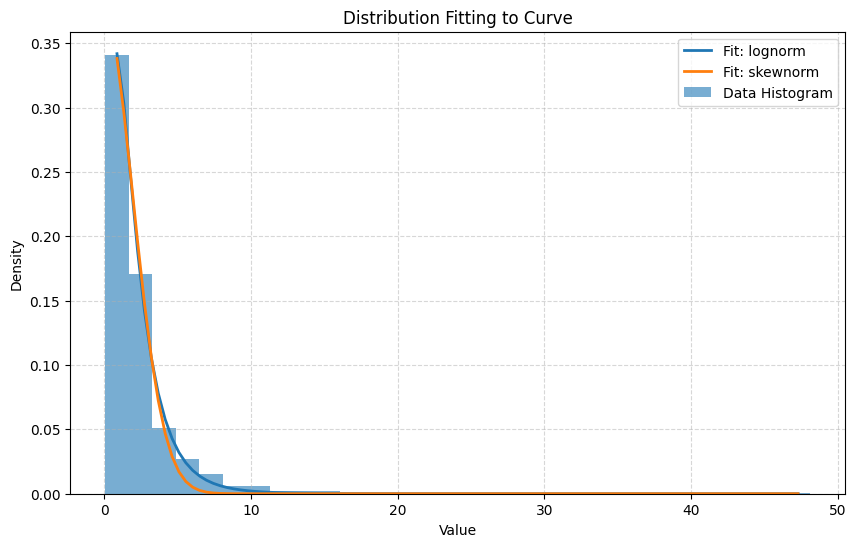

In [13]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_distributions_to_curve(x_data, y_data):
    """
    Fits various non-symmetric distributions to a given curve (x, y data)
    using curve_fit (least-squares).

    Args:
        x_data (np.ndarray): The x-coordinates of the curve (e.g., bin centers).
        y_data (np.ndarray): The y-coordinates of the curve (e.g., bin counts/density).

    Returns:
        dict: A dictionary of results with fit parameters and RMSE for each distribution.
    """
    if not isinstance(x_data, np.ndarray) or not isinstance(y_data, np.ndarray):
        raise ValueError("Inputs must be NumPy arrays.")

    # 1. Define model functions for each distribution's PDF
    def lognorm_pdf(x, s, loc, scale):
        return stats.lognorm.pdf(x, s, loc, scale)

    def skewnorm_pdf(x, a, loc, scale):
        return stats.skewnorm.pdf(x, a, loc, scale)

    # 2. Map distribution names to their model functions and initial parameter guesses
    # CORRECTED: The keys now match the scipy.stats attribute names
    distributions = {
        'lognorm': (lognorm_pdf, [1.0, np.min(x_data), np.std(x_data)]),
        'skewnorm': (skewnorm_pdf, [1.0, np.mean(x_data), np.std(x_data)]),
    }

    results = {}

    for dist_name, (model_func, p0_guess) in distributions.items():
        try:
            # Use curve_fit to find the best-fit parameters
            popt, pcov = curve_fit(model_func, x_data, y_data, p0=p0_guess, maxfev=5000)

            # Calculate the Root Mean Square Error (RMSE)
            y_fit = model_func(x_data, *popt)
            rmse = np.sqrt(np.mean((y_data - y_fit)**2))

            results[dist_name] = {
                'parameters': popt,
                'rmse': rmse
            }
        except Exception as e:
            print(f"Failed to fit {dist_name}: {e}")
            results[dist_name] = {'error': str(e)}

    return results

# --- Example Usage ---
# 1. Generate sample data from a log-normal distribution
np.random.seed(42)
sample_data = stats.lognorm.rvs(s=0.9, loc=0, scale=1.5, size=1000)

# 2. Create a representative curve (histogram) from the data
hist, bin_edges = np.histogram(sample_data, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 3. Fit the distributions to the histogram curve
fit_results = fit_distributions_to_curve(bin_centers, hist)

# 4. Print the results
print("--- Goodness-of-Fit Results (RMSE) ---")
for dist_name, result in fit_results.items():
    if 'error' in result:
        print(f"{dist_name}: Error during fitting - {result['error']}")
    else:
        print(f"\nDistribution: {dist_name}")
        print(f"  - Parameters: {np.round(result['parameters'], 4)}")
        print(f"  - RMSE: {result['rmse']:.4f}")

# 5. Visualize the fits
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist, width=np.diff(bin_edges), alpha=0.6, label='Data Histogram')
plt.title('Distribution Fitting to Curve')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)

x_plot = np.linspace(min(bin_centers), max(bin_centers), 100)
for dist_name, result in fit_results.items():
    if 'error' not in result:
        params = result['parameters']
        pdf_func = getattr(stats, dist_name)
        pdf_values = pdf_func.pdf(x_plot, *params)
        plt.plot(x_plot, pdf_values, label=f'Fit: {dist_name}', linewidth=2)

plt.legend()
plt.show()

In [132]:

import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy import integrate
import LS_Functions as lsf

from scipy.optimize import minimize, basinhopping
def fit_lognormal_phasor(target_gs, n_harmonics=6, T=256, initial_guess=None):
    """
    Fits the loc and scale parameters of a log-normal distribution to target
    G and S coordinates up to a specified harmonic.

    Args:
        target_g (np.ndarray): The target G coordinates from the phasor plot.
        target_s (np.ndarray): The target S coordinates from the phasor plot.
        n_harmonic (int): The number of harmonics to use in the fit.
        T (int): The period of the signal.

    Returns:
        tuple: A tuple containing the optimized (loc, scale) parameters.
    """
    def objective_function(params, *args):
        loc, scale = params
        
        # Fixed sigma as per the request
        sigma = 1.0
        
        # Guard against invalid parameters that would crash the PDF
        if scale <= 0:
            return np.inf

        # Generate a sample from the log-normal distribution to mimic a curve
        x = np.arange(T)
        y = stats.lognorm.pdf(x, s=sigma, loc=loc, scale=scale)
        
        # Get the G and S coordinates from the generated curve
        gs = np.zeros(n_harmonics*2)
        for i_harm,n_harm in enumerate(range(1, n_harmonics + 1)):
            g_calc, s_calc, _, _ = lsf.PhasorTransform_Slow_2D(y[:,None], axis=0, n_harmonic=n_harm)
            gs[i_harm*2:(i_harm*2+2)] = np.asarray([g_calc, s_calc])[:,0]
        # Calculate the total squared distance
        distance = np.sum((gs - target_gs)**2) + np.sum((gs - target_gs)**2)
        
        return distance


    # Initial guess for the parameters
    if initial_guess is None:
        initial_guess = [T / 2, T / 5]  # loc and scale

    minimizer_kwargs = {
        "method": "L-BFGS-B",
        "bounds": [(0.0, None), (0.0, None)], # loc and scale must be non-negative
        "args": (target_gs, n_harmonics, T)
    }    # Run the minimization
    result = basinhopping(
        objective_function,
        initial_guess,
        minimizer_kwargs=minimizer_kwargs,
        niter=100  # Number of hopping iterations to perform
    )

    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimization failed to converge.")

# --- Example Usage ---

# 1. Generate mock target data using a known log-normal distribution
#    This simulates having real data that you want to fit.
true_loc = 5
true_scale = 5
true_sigma = 1.0
n_harmonics = 6
T_period = 32

x_mock = np.arange(0, T_period)
y_mock = stats.lognorm.pdf(x_mock, s=1, loc=true_loc, scale=true_scale)

# Get the G,S coordinates for this mock data
gs_target = np.zeros(n_harmonics*2)
for i_harm,n_harm in enumerate(range(1, n_harmonics + 1)):
    target_g, target_s, _, _ = lsf.PhasorTransform_Slow_2D(y_mock[:,None], axis=0, n_harmonic=n_harm)
    gs_target[i_harm*2:(i_harm*2+2)] =  np.asarray([target_g, target_s])[:,0]

# 2. Run the fitting function
initial_guess = [true_loc*2, true_scale*10]
optimized_params = fit_lognormal_phasor(gs_target, n_harmonics=n_harmonics, T=T_period, initial_guess=initial_guess)

print("\n--- Fitting Results ---")
print(f"True Parameters: loc={true_loc}, scale={true_scale}")
print(f"Optimized Parameters: loc={optimized_params[0]:.4f}, scale={optimized_params[1]:.4f}")


--- Fitting Results ---
True Parameters: loc=5, scale=5
Optimized Parameters: loc=5.0000, scale=5.0000


[-0.02876212 -0.59575038 -0.01342063 -0.1031778  -0.05663726 -0.11909193
 -0.02233802 -0.08299592 -0.03480234 -0.05470199 -0.03529038 -0.05153633]
[-0.25305565  0.58531381 -0.40318227 -0.11835266 -0.00305379 -0.29356325
  0.19676851 -0.07590938  0.10673689  0.11709726 -0.05382367  0.11543303]
[-0.25305566  0.58531381 -0.40318226 -0.11835267 -0.00305378 -0.29356325
  0.19676851 -0.07590936  0.10673688  0.11709727 -0.05382368  0.11543301]


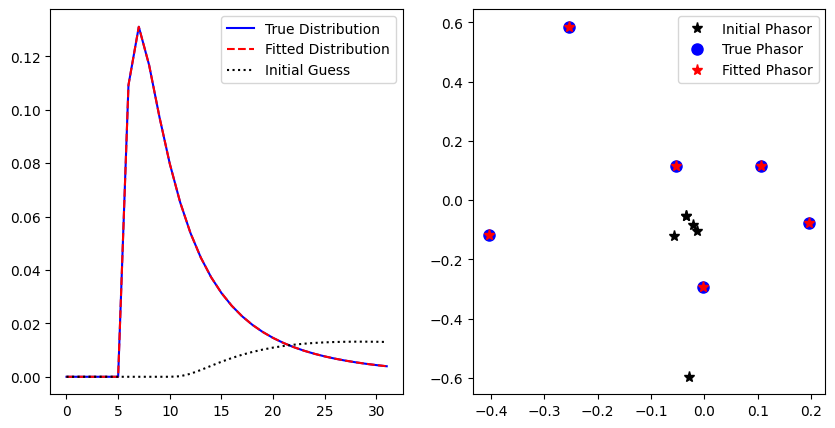

In [133]:
x = np.arange(T_period)
y = stats.lognorm.pdf(x, s=1, loc=true_loc, scale=true_scale)
y_fit = stats.lognorm.pdf(x, s=1, loc=optimized_params[0], scale=optimized_params[1])
y0 = stats.lognorm.pdf(x, s=1, loc=initial_guess[0], scale=initial_guess[1])

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x, y, '-',label='True Distribution', color='blue')
ax[0].plot(x, y_fit, '--',label='Fitted Distribution', color='red')
ax[0].plot(x, y0, ':k',label='Initial Guess')
ax[0].legend()
obj_gs = np.zeros(n_harmonics*2)
for i_harm,n_harm in enumerate(range(1, n_harmonics + 1)):
    obj_g, obj_s, _, _ = lsf.PhasorTransform_Slow_2D(y0[:,None], axis=0, n_harmonic=n_harm)
    obj_gs[i_harm*2:(i_harm*2+2)] =  np.asarray([obj_g, obj_s])[:,0]
print(obj_gs)
ax[1].plot(obj_gs[0::2], obj_gs[1::2], '*', color='black', label='Initial Phasor', markersize=8)
obj_gs = np.zeros(n_harmonics*2)
for i_harm,n_harm in enumerate(range(1, n_harmonics + 1)):
    obj_g, obj_s, _, _ = lsf.PhasorTransform_Slow_2D(y[:,None], axis=0, n_harmonic=n_harm)
    obj_gs[i_harm*2:(i_harm*2+2)] =  np.asarray([obj_g, obj_s])[:,0]
print(obj_gs)
ax[1].plot(obj_gs[0::2], obj_gs[1::2], 'o', color='blue', label='True Phasor', markersize=8)
obj_gs = np.zeros(n_harmonics*2)
for i_harm,n_harm in enumerate(range(1, n_harmonics + 1)):
    obj_g, obj_s, _, _ = lsf.PhasorTransform_Slow_2D(y_fit[:,None], axis=0, n_harmonic=n_harm)
    obj_gs[i_harm*2:(i_harm*2+2)] =  np.asarray([obj_g, obj_s])[:,0]
print(obj_gs)
ax[1].plot(obj_gs[0::2], obj_gs[1::2], '*', color='red', label='Fitted Phasor', markersize=8)
ax[1].legend()


In [36]:
 np.asarray([target_g, target_s])[:,0]

array([-0.59896473, -0.29572576])

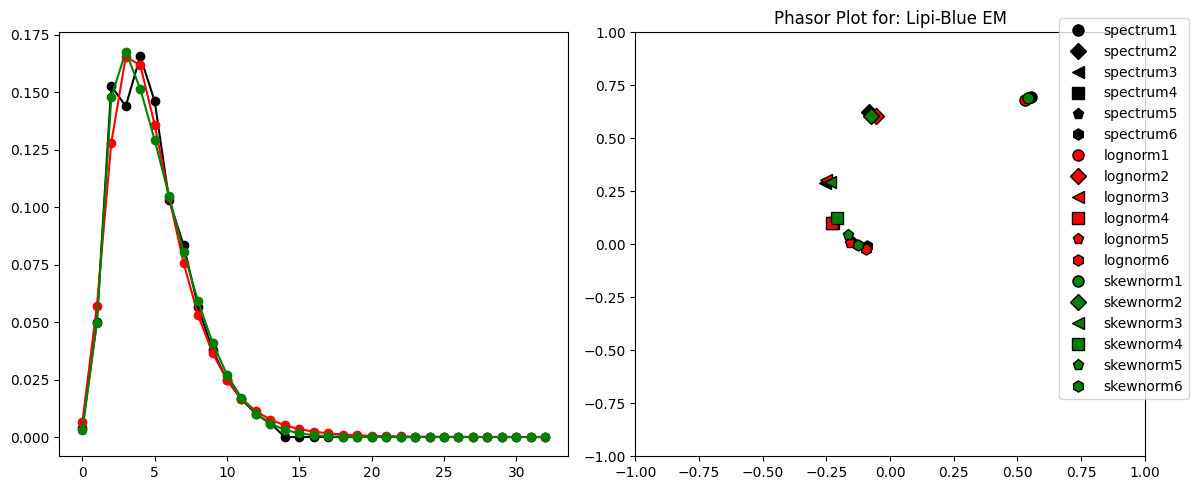

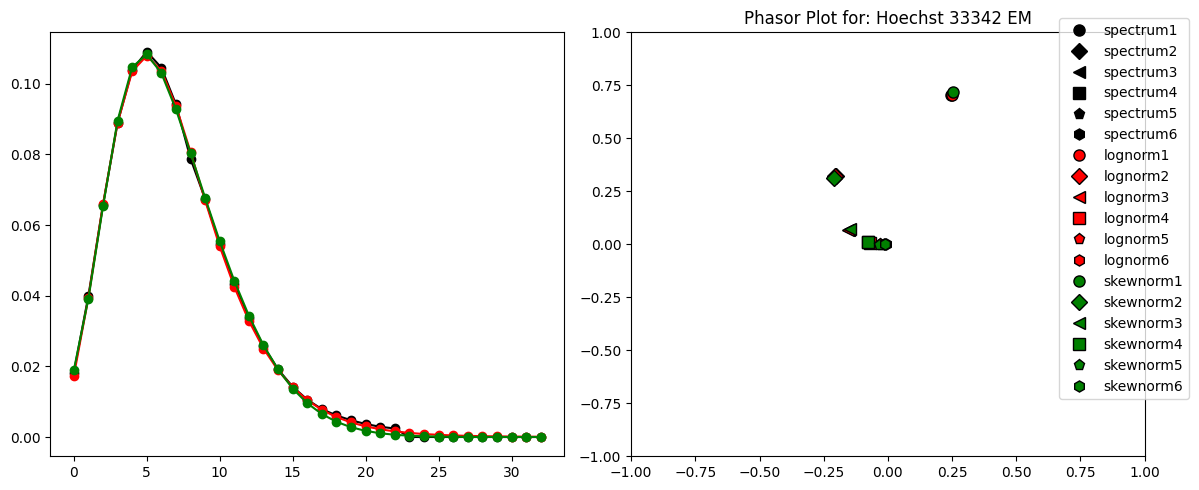

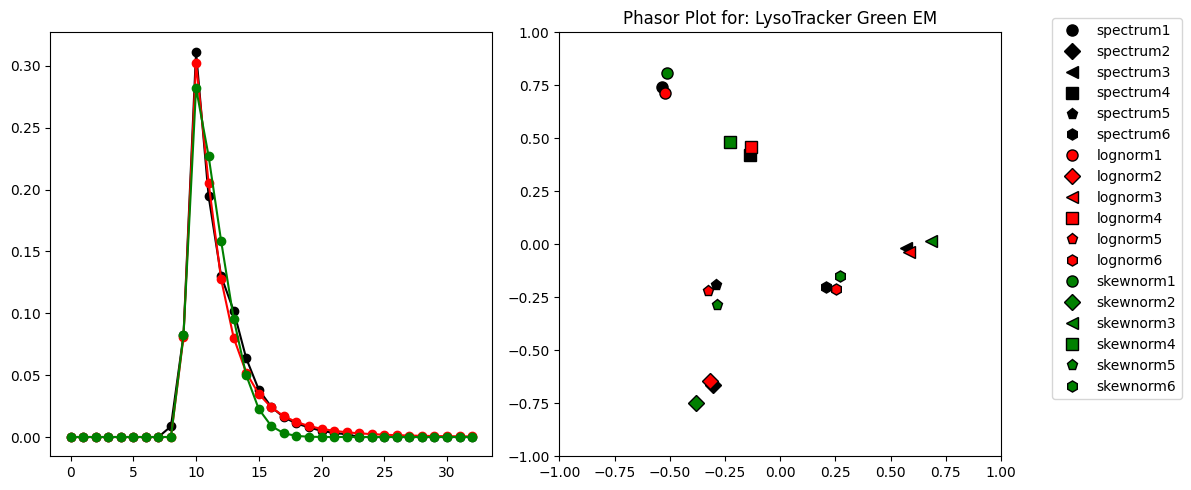

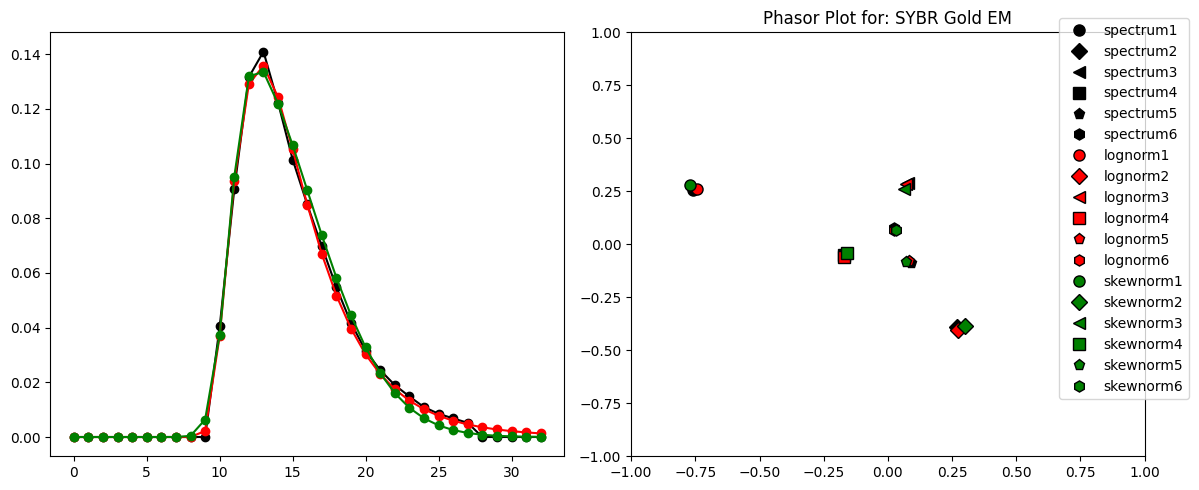

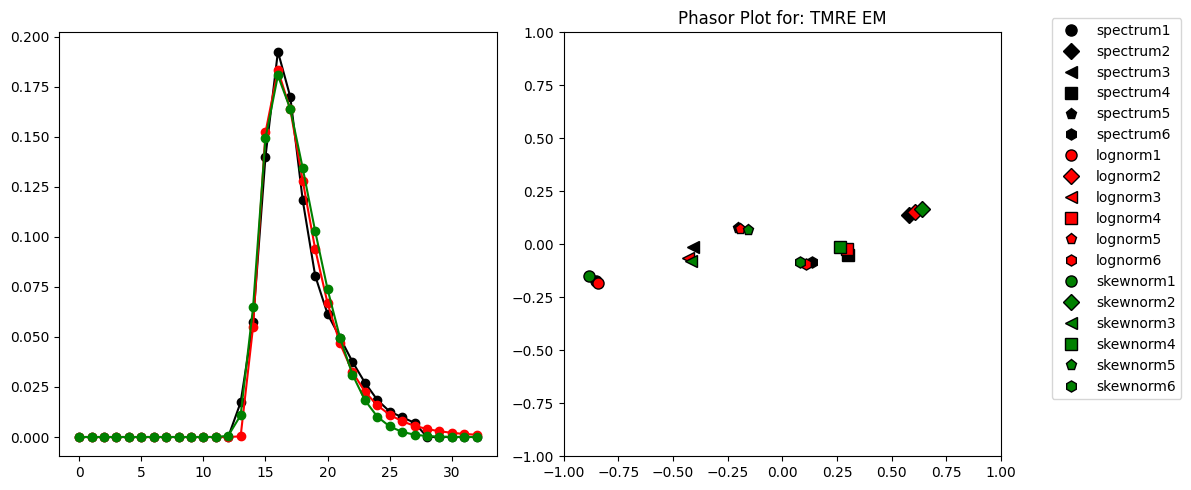

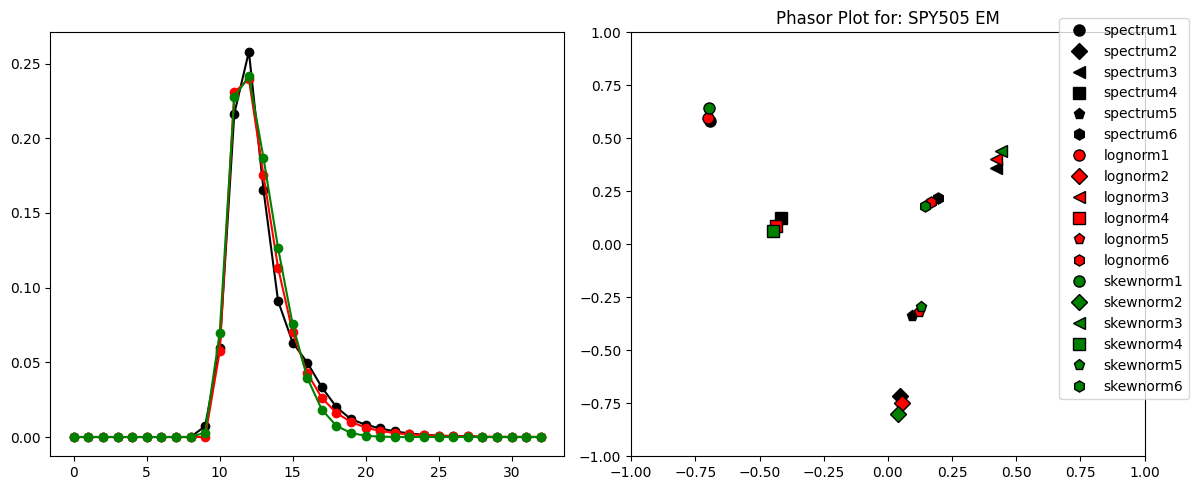

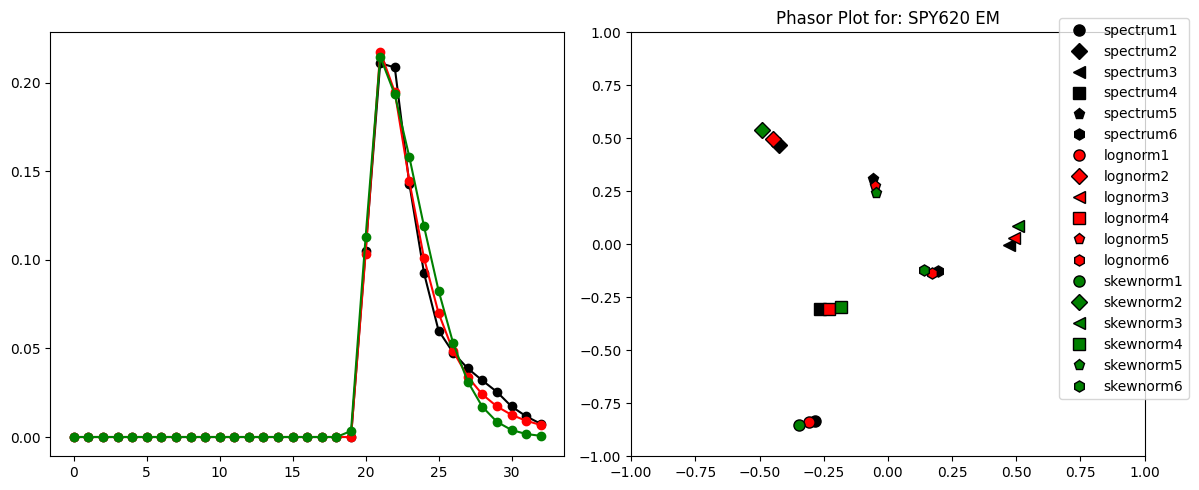

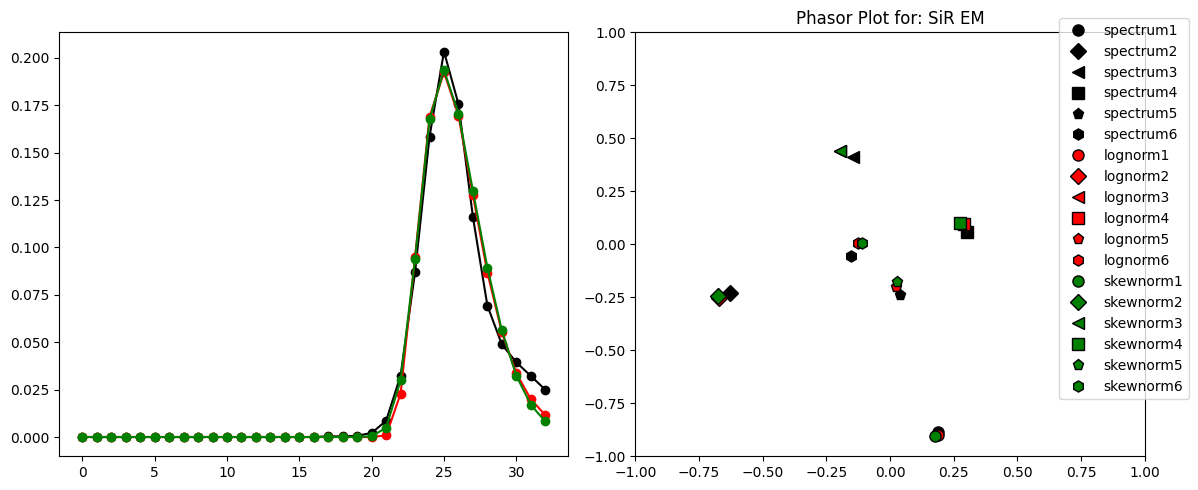

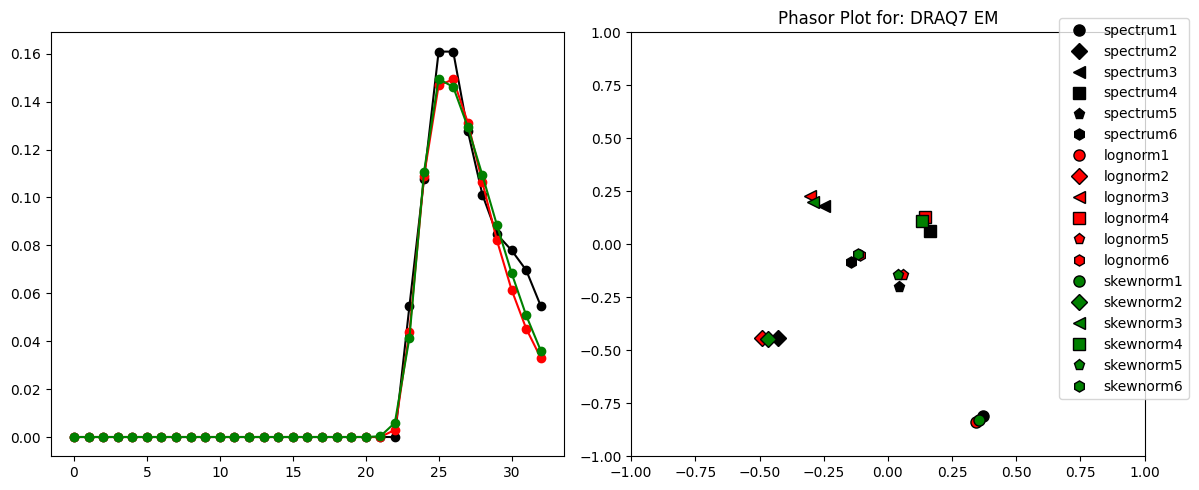

In [16]:
colors = 'krgcmybwr'
markers = 'oD<sph8'
phasor_results = {}

for dye_name in df_filtered.columns[1:]:
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    idx = 0

    y = df_filtered[dye_name].values
    y = y / np.sum(y)
    x = np.arange(len(y))
    phasor_results[dye_name] = {'spectrum': []}
    # Calculate phasor parameters for harmonics 1 to 6 for the spectrum
    for n in range(1, 7):
        g, s, ph, m = lsf.PhasorTransform_Slow_2D(y[:, None], axis=0, n_harmonic=n)
        phasor_results[dye_name]['spectrum'].append({'g'+str(n): g[0], 's'+str(n): s[0], 'ph'+str(n): ph[0], 'm'+str(n): m[0]})

    # Calculate phasor parameters for each fitted curve
    fit_results = fit_distributions_to_curve(np.arange(len(y)), y)
    idx_distr = 1
    ax[0].plot(x, y, '-o', label='Data', color=colors[0])
    for dist_name, result in fit_results.items():
        if 'error' not in result:
            params = result['parameters']
            pdf_func = getattr(stats, dist_name)
            fit_curve = pdf_func.pdf(x, *params)
            phasor_results[dye_name][dist_name] = []
            ax[0].plot(x, fit_curve, '-o',label=dist_name, color=colors[idx_distr])
            for n in range(1, 7):
                g, s, ph, m = lsf.PhasorTransform_Slow_2D(fit_curve[:, None], axis=0, n_harmonic=n)
                phasor_results[dye_name][dist_name].append({'g'+str(n): g[0], 's'+str(n): s[0], 'ph'+str(n): ph[0], 'm'+str(n): m[0]})
        else:
            phasor_results[dye_name][dist_name] = [None] * 6
        idx_distr += 1

    for key,data in phasor_results[dye_name].items():    
        for n in range(1, 7):
            ax[1].plot(data[n-1]['g'+str(n)],data[n-1]['s'+str(n)], 
                       markers[n-1], 
                       label=key+str(n), 
                       markerfacecolor=colors[idx],
                       markeredgecolor='k',
                       markersize=8)
        idx += 1

    ax[1].set_xlim((-1,1))
    ax[1].set_ylim((-1,1))
    ax[1].set_title('Phasor Plot for: '+dye_name)
    ax[1].legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.savefig('phasor_plot_'+dye_name+'.png')
    plt.show()